# Driver Performance & Correlation Analysis

This notebook analyzes all driver CSV files and finds correlations with telemetry and other datasets.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Configuration
DATASETS_CLEAN = r"../datasets_clean"

## Data Loading Functions

In [2]:
def load_all_driver_data():
    """Load and combine all driver CSV files"""
    driver_files = glob.glob(os.path.join(DATASETS_CLEAN, "driver_*.csv"))
    driver_files = [f for f in driver_files if not f.endswith("driver_session_stats.csv")]
    
    all_drivers = []
    for file in driver_files:
        df = pd.read_csv(file)
        driver_num = int(os.path.basename(file).replace("driver_", "").replace(".csv", ""))
        df['DRIVER_NUM'] = driver_num
        all_drivers.append(df)
    
    return pd.concat(all_drivers, ignore_index=True)

def load_telemetry_data():
    """Load telemetry summary data"""
    return pd.read_csv(os.path.join(DATASETS_CLEAN, "per_lap_telemetry_summary.csv"))

def load_session_stats():
    """Load driver session statistics"""
    return pd.read_csv(os.path.join(DATASETS_CLEAN, "driver_session_stats.csv"))

## Load All Data

In [3]:
# Load all datasets
print("Loading driver data...")
drivers_df = load_all_driver_data()

print("Loading telemetry data...")
telemetry_df = load_telemetry_data()

print("Loading session stats...")
session_stats = load_session_stats()

print(f"\nData loaded successfully:")
print(f"- Drivers: {drivers_df['DRIVER_NUM'].nunique()} unique drivers")
print(f"- Total laps: {len(drivers_df)}")
print(f"- Telemetry records: {len(telemetry_df)}")
print(f"- Session stats: {len(session_stats)} drivers")

Loading driver data...
Loading telemetry data...
Loading session stats...

Data loaded successfully:
- Drivers: 29 unique drivers
- Total laps: 325
- Telemetry records: 346
- Session stats: 29 drivers


## Data Overview

In [4]:
# Display basic info about the datasets
print("=== DRIVER DATA OVERVIEW ===")
print(drivers_df.info())
print("\nFirst few rows:")
display(drivers_df.head())

=== DRIVER DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   NUMBER                       325 non-null    int64  
 1   DRIVER_NUMBER                325 non-null    int64  
 2   LAP_NUMBER                   325 non-null    int64  
 3   LAP_TIME                     325 non-null    object 
 4   LAP_IMPROVEMENT              325 non-null    int64  
 5   CROSSING_FINISH_LINE_IN_PIT  0 non-null      float64
 6   S1                           325 non-null    float64
 7   S1_IMPROVEMENT               325 non-null    int64  
 8   S2                           325 non-null    object 
 9   S2_IMPROVEMENT               325 non-null    int64  
 10  S3                           325 non-null    object 
 11  S3_IMPROVEMENT               325 non-null    int64  
 12  KPH                          325 non-null    floa

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,IM2_elapsed,IM3a_time,IM3a_elapsed,FL_time,FL_elapsed,LAP_TIME_SEC,S1_SEC,S2_SEC,S3_SEC,DRIVER_NUM
0,11,1,3,2:32.202,0,NaN,33.813,0,58.094,0,...,1:31.907,29.153,2:01.060,31.142,2:32.202,152.202,33.813,58.094,60.295,11
1,11,1,4,2:31.972,0,NaN,33.082,0,58.353,0,...,1:31.435,29.446,2:00.881,31.091,2:31.972,151.972,33.082,58.353,60.537,11
2,11,1,5,2:32.347,0,NaN,33.212,0,58.249,0,...,1:31.461,29.380,2:00.841,31.506,2:32.347,152.347,33.212,58.249,60.886,11
3,11,1,6,2:32.287,0,NaN,33.048,2,58.334,0,...,1:31.382,29.853,2:01.235,31.052,2:32.287,152.287,33.048,58.334,60.905,11
4,11,1,7,2:31.915,0,NaN,33.311,0,58.343,0,...,1:31.654,29.006,2:00.660,31.255,2:31.915,151.915,33.311,58.343,60.261,11


In [5]:
print("=== TELEMETRY DATA OVERVIEW ===")
print(telemetry_df.info())
print("\nFirst few rows:")
display(telemetry_df.head())

=== TELEMETRY DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vehicle_id           346 non-null    object 
 1   lap                  346 non-null    int64  
 2   mean_throttle        346 non-null    float64
 3   mean_brake           346 non-null    float64
 4   steering_smoothness  346 non-null    float64
 5   NUMBER               346 non-null    int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 16.3+ KB
None

First few rows:


,vehicle_id,lap,mean_throttle,mean_brake,steering_smoothness,NUMBER
0,GR86-037-03,3,73.330397,5.741709,3.380900,3
1,GR86-037-03,4,74.700957,6.678829,2.559498,3
2,GR86-037-03,5,73.703448,6.386471,2.362693,3
3,GR86-037-03,6,75.760859,6.613510,2.129545,3
4,GR86-037-03,7,75.751863,6.249380,2.131221,3


In [6]:
print("=== SESSION STATS OVERVIEW ===")
display(session_stats.head(10))

=== SESSION STATS OVERVIEW ===


,DriverNumber,Laps,BestLap(s),AvgLap(s),StdDev(s),S1Best,S2Best,S3Best,TheoreticalBest(s)
0,3,23,151.035,152.509,0.889,32.914,57.593,60.037,150.544
1,5,12,150.848,152.119,1.002,32.758,57.820,59.768,150.346
2,7,12,148.678,149.221,0.450,32.544,56.689,59.129,148.362
3,8,11,153.790,155.357,1.061,33.467,58.681,61.245,153.393
4,11,8,151.702,152.245,0.399,33.048,57.988,60.261,151.297
5,13,13,148.745,149.498,0.688,32.526,56.786,59.131,148.443
6,14,12,150.363,151.495,0.932,32.837,57.505,59.468,149.810
7,15,3,151.899,152.039,0.140,33.127,58.301,60.320,151.748
8,16,12,148.726,149.288,0.464,32.431,56.909,59.189,148.529
9,18,11,153.543,155.986,1.495,33.551,58.470,61.343,153.364


## Driver Performance Analysis

=== LAP COUNT BY DRIVER ===
DRIVER_NUM
3      23
13     13
46     13
14     12
5      12
41     12
21     12
16     12
72     12
57     12
55     12
47     12
7      12
93     12
71     12
86     12
88     12
8      11
73     11
98     11
18     11
78     11
89     10
113    10
80     10
11      8
51      7
31      5
15      3
dtype: int64


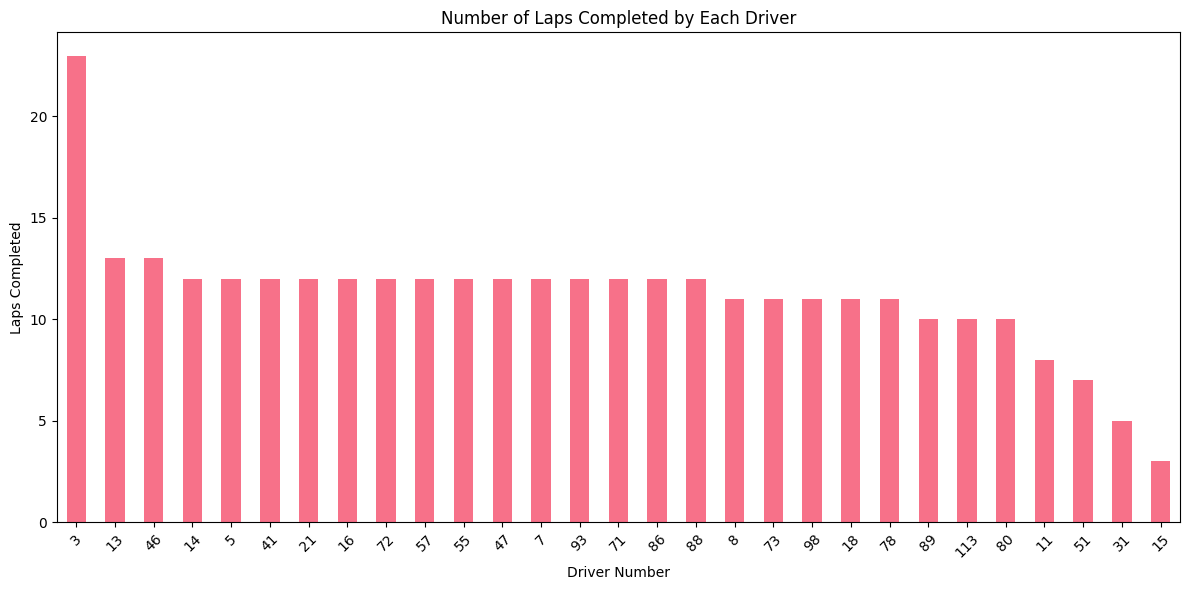

In [7]:
# Lap count distribution
lap_counts = drivers_df.groupby('DRIVER_NUM').size().sort_values(ascending=False)
print("=== LAP COUNT BY DRIVER ===")
print(lap_counts)

# Visualize lap count distribution
plt.figure(figsize=(12, 6))
lap_counts.plot(kind='bar')
plt.title('Number of Laps Completed by Each Driver')
plt.xlabel('Driver Number')
plt.ylabel('Laps Completed')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== BEST LAP TIMES BY DRIVER ===
DRIVER_NUM
46     148.630
7      148.678
55     148.679
16     148.726
13     148.745
72     148.848
21     148.989
41     149.262
78     149.293
88     149.418
71     149.526
47     149.690
89     149.744
113    149.926
98     149.983
31     150.244
14     150.363
5      150.848
3      151.035
93     151.169
11     151.702
15     151.899
73     152.063
80     152.369
86     153.294
18     153.543
51     153.568
57     153.619
8      153.790
Name: LAP_TIME_SEC, dtype: float64


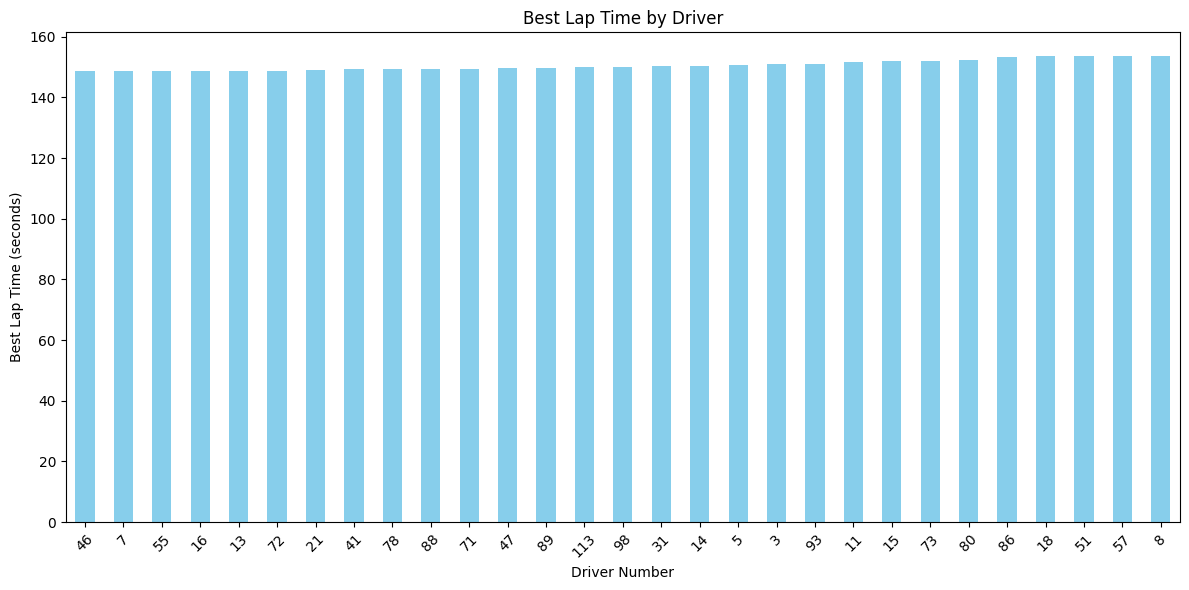

In [8]:
# Best lap times analysis
best_laps = drivers_df.groupby('DRIVER_NUM')['LAP_TIME_SEC'].min().sort_values()
print("=== BEST LAP TIMES BY DRIVER ===")
print(best_laps)

# Visualize best lap times
plt.figure(figsize=(12, 6))
best_laps.plot(kind='bar', color='skyblue')
plt.title('Best Lap Time by Driver')
plt.xlabel('Driver Number')
plt.ylabel('Best Lap Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Sector performance analysis
sector_stats = drivers_df.groupby('DRIVER_NUM').agg({
    'S1_SEC': ['mean', 'min', 'std'],
    'S2_SEC': ['mean', 'min', 'std'], 
    'S3_SEC': ['mean', 'min', 'std'],
    'LAP_TIME_SEC': ['mean', 'min', 'std'],
    'TOP_SPEED': ['mean', 'max', 'std']
}).round(3)

print("=== SECTOR PERFORMANCE ANALYSIS ===")
print("\nTop 10 drivers by average S1 time:")
print(sector_stats['S1_SEC']['mean'].sort_values().head(10))

print("\nTop 10 drivers by average S2 time:")
print(sector_stats['S2_SEC']['mean'].sort_values().head(10))

print("\nTop 10 drivers by average S3 time:")
print(sector_stats['S3_SEC']['mean'].sort_values().head(10))

=== SECTOR PERFORMANCE ANALYSIS ===

Top 10 drivers by average S1 time:
DRIVER_NUM
16     32.583
7      32.667
72     32.670
13     32.700
41     32.707
46     32.753
55     32.765
78     32.775
71     32.811
113    32.815
Name: mean, dtype: float64

Top 10 drivers by average S2 time:
DRIVER_NUM
7     57.070
46    57.147
16    57.222
13    57.267
55    57.275
72    57.344
21    57.509
78    57.519
71    57.625
89    57.781
Name: mean, dtype: float64

Top 10 drivers by average S3 time:
DRIVER_NUM
55    59.342
46    59.415
16    59.482
7     59.484
72    59.520
13    59.531
78    59.533
41    59.566
98    59.711
21    59.824
Name: mean, dtype: float64


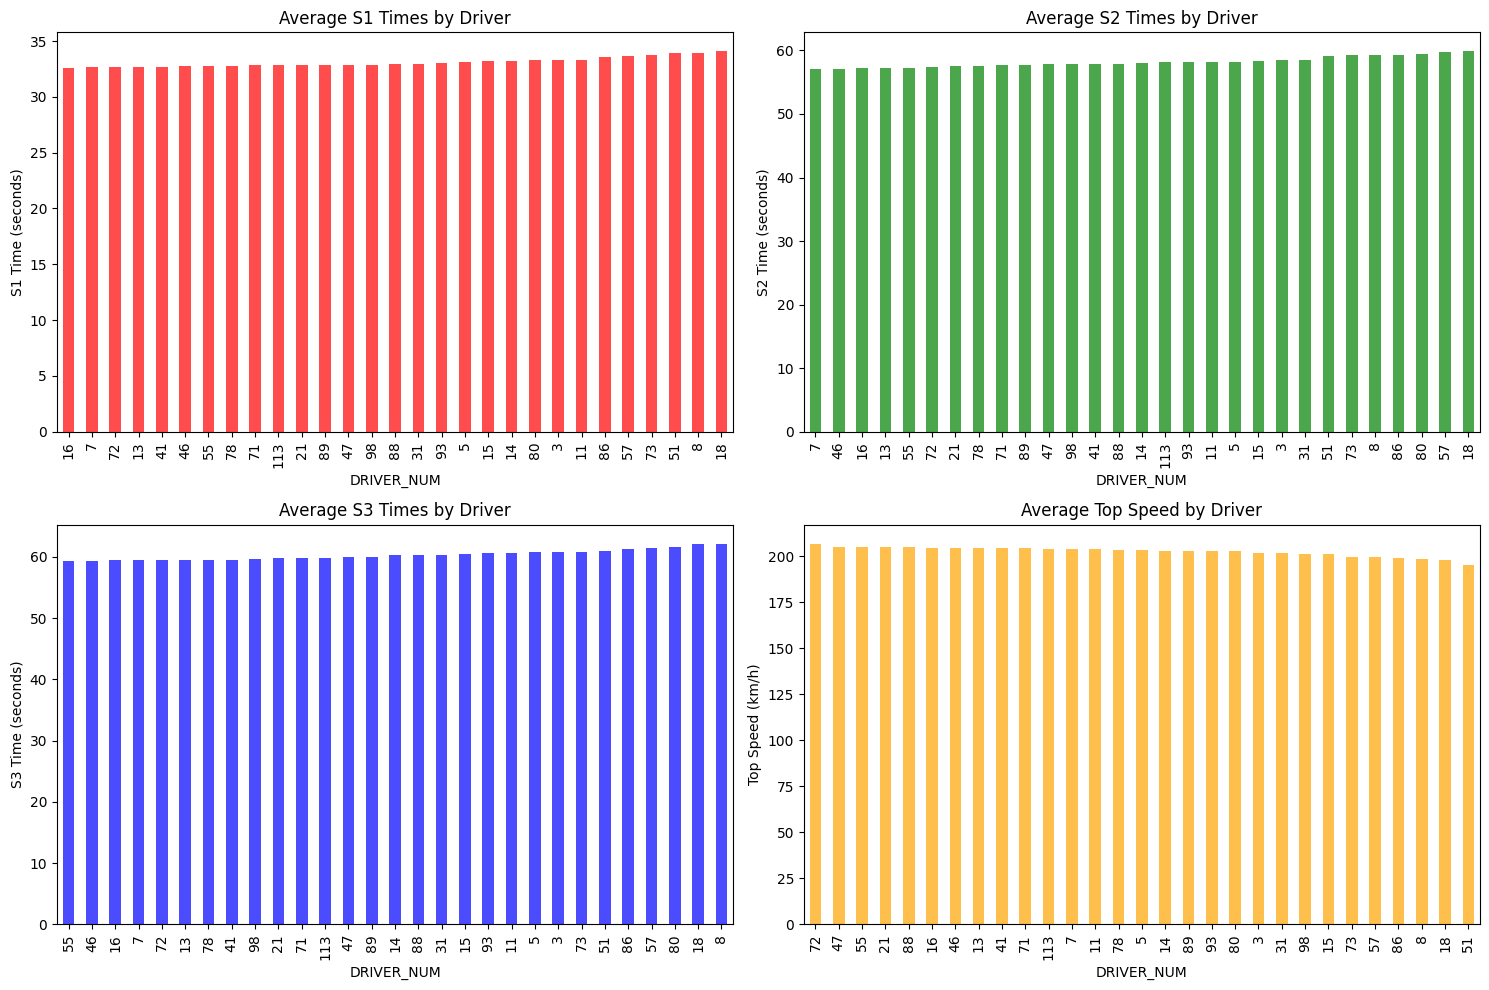

In [10]:
# Visualize sector performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# S1 times
sector_stats['S1_SEC']['mean'].sort_values().plot(kind='bar', ax=axes[0,0], color='red', alpha=0.7)
axes[0,0].set_title('Average S1 Times by Driver')
axes[0,0].set_ylabel('S1 Time (seconds)')

# S2 times
sector_stats['S2_SEC']['mean'].sort_values().plot(kind='bar', ax=axes[0,1], color='green', alpha=0.7)
axes[0,1].set_title('Average S2 Times by Driver')
axes[0,1].set_ylabel('S2 Time (seconds)')

# S3 times
sector_stats['S3_SEC']['mean'].sort_values().plot(kind='bar', ax=axes[1,0], color='blue', alpha=0.7)
axes[1,0].set_title('Average S3 Times by Driver')
axes[1,0].set_ylabel('S3 Time (seconds)')

# Top speeds
sector_stats['TOP_SPEED']['mean'].sort_values(ascending=False).plot(kind='bar', ax=axes[1,1], color='orange', alpha=0.7)
axes[1,1].set_title('Average Top Speed by Driver')
axes[1,1].set_ylabel('Top Speed (km/h)')

plt.tight_layout()
plt.show()

## Driver-Telemetry Correlations

In [11]:
# Merge driver data with telemetry
merged_df = pd.merge(
    drivers_df, 
    telemetry_df, 
    left_on=['DRIVER_NUM', 'LAP_NUMBER'], 
    right_on=['NUMBER', 'lap'], 
    how='inner'
)

print(f"Successfully merged {len(merged_df)} lap records with telemetry data")
print(f"Coverage: {len(merged_df)/len(drivers_df)*100:.1f}% of driver laps have telemetry")

display(merged_df.head())

Successfully merged 295 lap records with telemetry data
Coverage: 90.8% of driver laps have telemetry


,NUMBER_x,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_SEC,S2_SEC,S3_SEC,DRIVER_NUM,vehicle_id,lap,mean_throttle,mean_brake,steering_smoothness,NUMBER_y
0,11,1,3,2:32.202,0,NaN,33.813,0,58.094,0,...,33.813,58.094,60.295,11,GR86-035-11,3,68.672790,4.961131,1.631102,11
1,11,1,4,2:31.972,0,NaN,33.082,0,58.353,0,...,33.082,58.353,60.537,11,GR86-035-11,4,70.632138,5.635305,1.719262,11
2,11,1,5,2:32.347,0,NaN,33.212,0,58.249,0,...,33.212,58.249,60.886,11,GR86-035-11,5,71.221126,5.475949,2.095993,11
3,11,1,6,2:32.287,0,NaN,33.048,2,58.334,0,...,33.048,58.334,60.905,11,GR86-035-11,6,72.191864,5.388305,1.892807,11
4,11,1,7,2:31.915,0,NaN,33.311,0,58.343,0,...,33.311,58.343,60.261,11,GR86-035-11,7,71.452296,4.982152,1.774565,11


In [12]:
# Calculate correlations
correlations = {}
metrics = ['mean_throttle', 'mean_brake', 'steering_smoothness']
performance_vars = ['LAP_TIME_SEC', 'S1_SEC', 'S2_SEC', 'S3_SEC', 'TOP_SPEED']

print("=== CORRELATION ANALYSIS ===")
correlation_matrix = []

for perf_var in performance_vars:
    row = []
    for metric in metrics:
        if metric in merged_df.columns and perf_var in merged_df.columns:
            # Remove NaN values
            clean_data = merged_df[[perf_var, metric]].dropna()
            if len(clean_data) > 10:  # Need sufficient data points
                corr_coef, p_value = pearsonr(clean_data[perf_var], clean_data[metric])
                correlations[f'{perf_var}_vs_{metric}'] = {'correlation': corr_coef, 'p_value': p_value}
                row.append(corr_coef)
            else:
                row.append(np.nan)
        else:
            row.append(np.nan)
    correlation_matrix.append(row)

# Create correlation matrix DataFrame
corr_df = pd.DataFrame(correlation_matrix, 
                      index=performance_vars, 
                      columns=metrics)

print("\nCorrelation Matrix:")
display(corr_df.round(3))

=== CORRELATION ANALYSIS ===

Correlation Matrix:


,mean_throttle,mean_brake,steering_smoothness
LAP_TIME_SEC,-0.640,-0.401,-0.505
S1_SEC,-0.583,-0.399,-0.415
S2_SEC,-0.562,-0.347,-0.458
S3_SEC,-0.591,-0.356,-0.476
TOP_SPEED,0.382,0.262,0.358


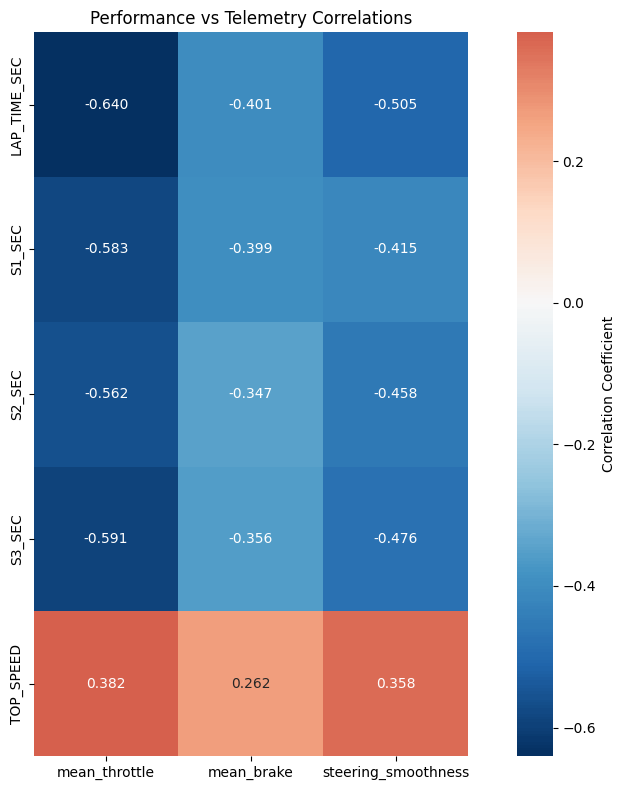

In [13]:
# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Performance vs Telemetry Correlations')
plt.tight_layout()
plt.show()

In [14]:
# Show significant correlations
print("=== SIGNIFICANT CORRELATIONS (p < 0.05) ===")
significant_corrs = []
for key, value in correlations.items():
    if value['p_value'] < 0.05:
        significant_corrs.append({
            'Variables': key,
            'Correlation': value['correlation'],
            'P-value': value['p_value']
        })

if significant_corrs:
    sig_df = pd.DataFrame(significant_corrs)
    sig_df = sig_df.sort_values('Correlation', key=abs, ascending=False)
    display(sig_df)
else:
    print("No statistically significant correlations found.")

=== SIGNIFICANT CORRELATIONS (p < 0.05) ===


,Variables,Correlation,P-value
0,LAP_TIME_SEC_vs_mean_throttle,-0.640414,1.885143e-35
9,S3_SEC_vs_mean_throttle,-0.590561,4.045975e-29
3,S1_SEC_vs_mean_throttle,-0.583162,2.852046e-28
6,S2_SEC_vs_mean_throttle,-0.561878,6.002010e-26
2,LAP_TIME_SEC_vs_steering_smoothness,-0.505435,1.554050e-20
11,S3_SEC_vs_steering_smoothness,-0.475774,4.536397e-18
8,S2_SEC_vs_steering_smoothness,-0.457512,1.147274e-16
5,S1_SEC_vs_steering_smoothness,-0.414869,1.061487e-13
1,LAP_TIME_SEC_vs_mean_brake,-0.400852,8.184674e-13
4,S1_SEC_vs_mean_brake,-0.399319,1.017407e-12


## Scatter Plots for Key Relationships

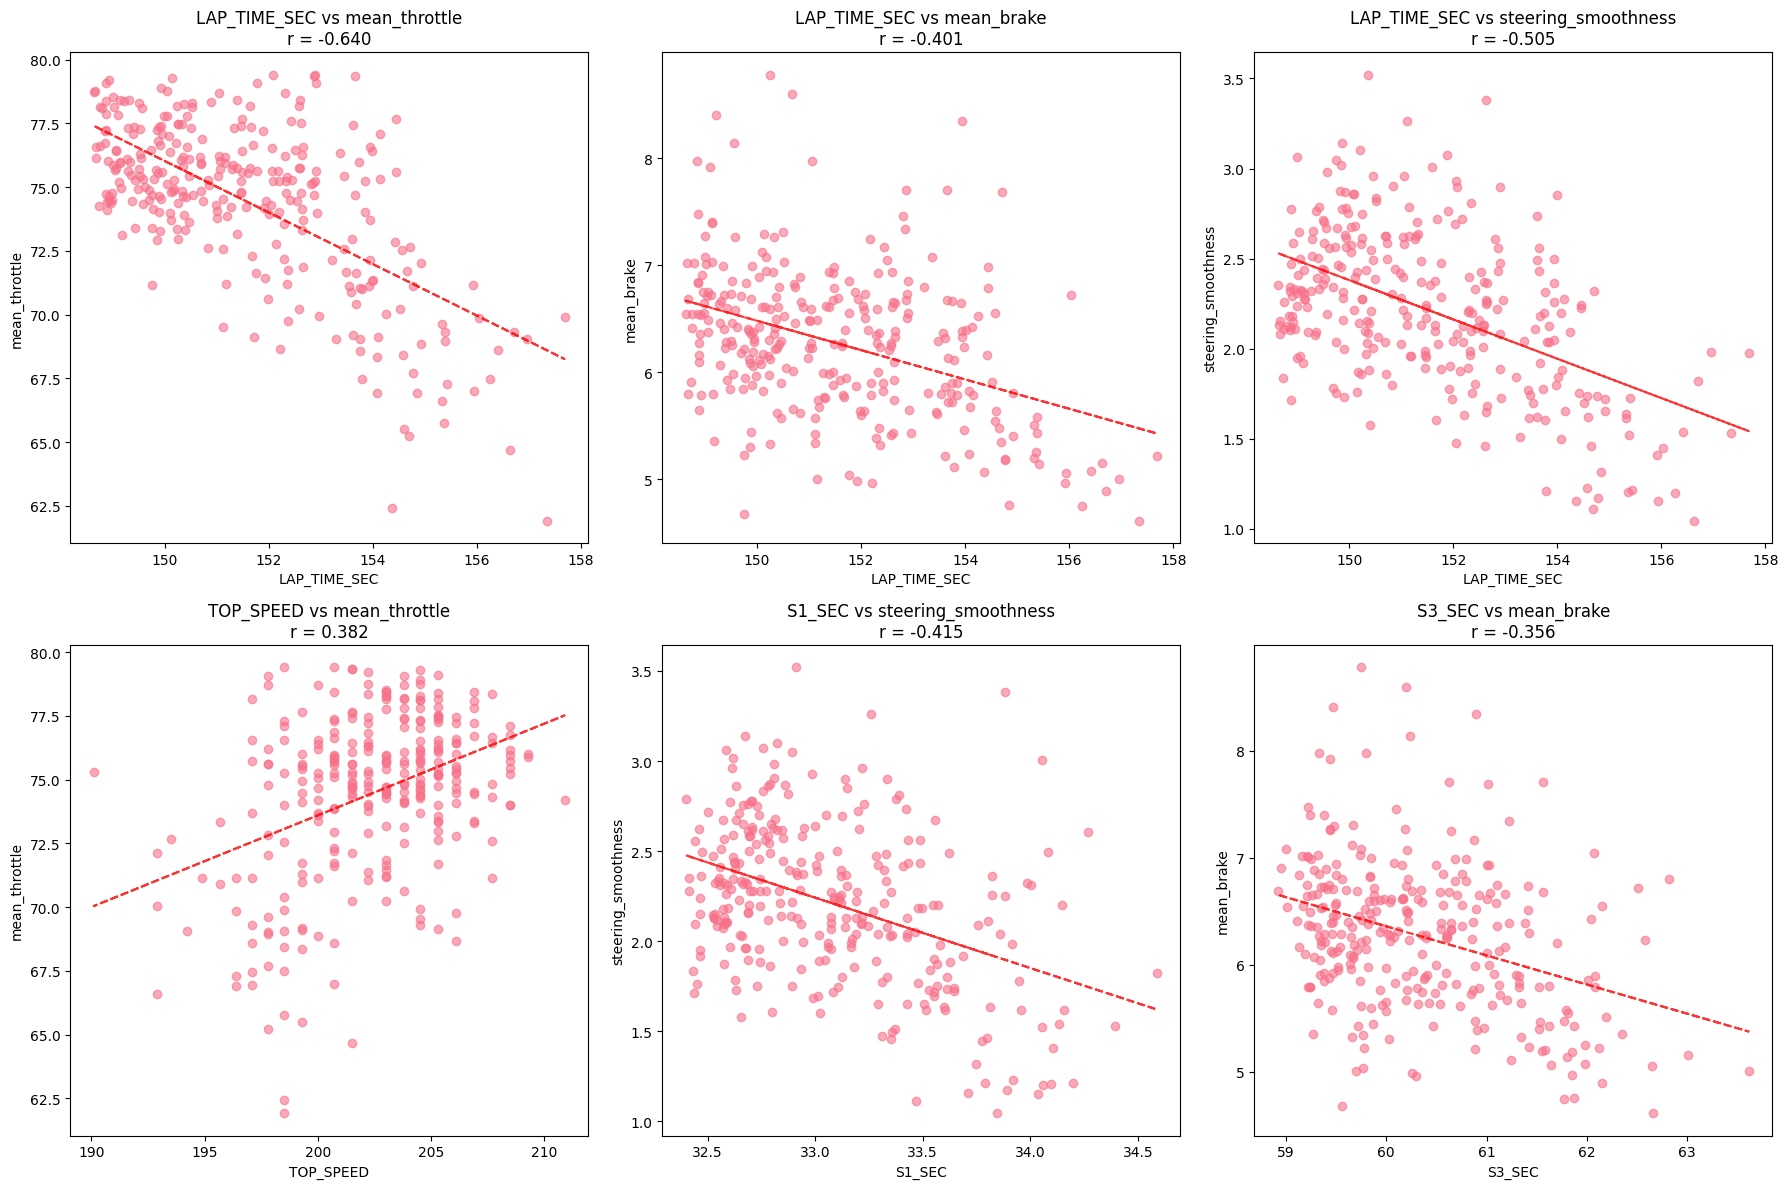

In [15]:
# Create scatter plots for key relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

plot_pairs = [
    ('LAP_TIME_SEC', 'mean_throttle'),
    ('LAP_TIME_SEC', 'mean_brake'),
    ('LAP_TIME_SEC', 'steering_smoothness'),
    ('TOP_SPEED', 'mean_throttle'),
    ('S1_SEC', 'steering_smoothness'),
    ('S3_SEC', 'mean_brake')
]

for i, (x_var, y_var) in enumerate(plot_pairs):
    if x_var in merged_df.columns and y_var in merged_df.columns:
        clean_data = merged_df[[x_var, y_var]].dropna()
        if len(clean_data) > 0:
            axes[i].scatter(clean_data[x_var], clean_data[y_var], alpha=0.6)
            axes[i].set_xlabel(x_var)
            axes[i].set_ylabel(y_var)
            
            # Add trend line
            z = np.polyfit(clean_data[x_var], clean_data[y_var], 1)
            p = np.poly1d(z)
            axes[i].plot(clean_data[x_var], p(clean_data[x_var]), "r--", alpha=0.8)
            
            # Add correlation coefficient
            corr, _ = pearsonr(clean_data[x_var], clean_data[y_var])
            axes[i].set_title(f'{x_var} vs {y_var}\nr = {corr:.3f}')

plt.tight_layout()
plt.show()

## Consistency Analysis

In [16]:
# Analyze driver consistency
consistency_stats = drivers_df.groupby('DRIVER_NUM').agg({
    'LAP_TIME_SEC': ['std', 'count', 'mean'],
    'S1_SEC': 'std',
    'S2_SEC': 'std', 
    'S3_SEC': 'std',
    'TOP_SPEED': ['mean', 'std']
}).round(3)

# Filter drivers with at least 5 laps
min_laps = 5
consistent_drivers = consistency_stats[consistency_stats[('LAP_TIME_SEC', 'count')] >= min_laps]

print(f"=== CONSISTENCY ANALYSIS (min {min_laps} laps) ===")
print("\nMost consistent drivers (lowest lap time std dev):")
most_consistent = consistent_drivers[('LAP_TIME_SEC', 'std')].sort_values()
print(most_consistent.head(10))

print("\nMost consistent top speeds (lowest std dev):")
speed_consistency = consistent_drivers[('TOP_SPEED', 'std')].sort_values()
print(speed_consistency.head(10))

=== CONSISTENCY ANALYSIS (min 5 laps) ===

Most consistent drivers (lowest lap time std dev):
DRIVER_NUM
98    0.303
51    0.370
11    0.399
7     0.450
16    0.464
78    0.466
71    0.498
93    0.537
46    0.557
72    0.581
Name: (LAP_TIME_SEC, std), dtype: float64

Most consistent top speeds (lowest std dev):
DRIVER_NUM
55     1.029
13     1.203
16     1.271
57     1.387
8      1.537
78     1.576
11     1.666
113    1.698
46     1.863
73     1.865
Name: (TOP_SPEED, std), dtype: float64


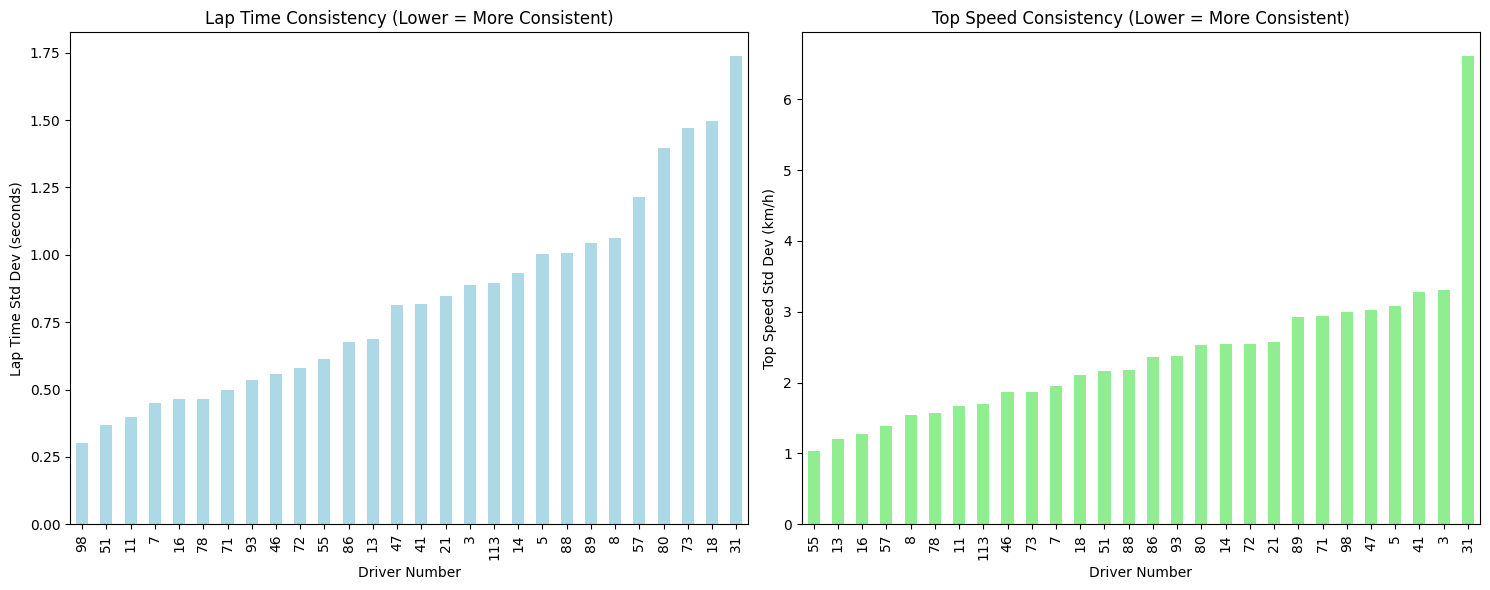

In [17]:
# Visualize consistency
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Lap time consistency
most_consistent.plot(kind='bar', ax=axes[0], color='lightblue')
axes[0].set_title('Lap Time Consistency (Lower = More Consistent)')
axes[0].set_ylabel('Lap Time Std Dev (seconds)')
axes[0].set_xlabel('Driver Number')

# Speed consistency
speed_consistency.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Top Speed Consistency (Lower = More Consistent)')
axes[1].set_ylabel('Top Speed Std Dev (km/h)')
axes[1].set_xlabel('Driver Number')

plt.tight_layout()
plt.show()

## Performance Trends Analysis

In [18]:
# Analyze performance trends throughout the session
trends = []

for driver in drivers_df['DRIVER_NUM'].unique():
    driver_data = drivers_df[drivers_df['DRIVER_NUM'] == driver].sort_values('LAP_NUMBER')
    
    if len(driver_data) >= 3:  # Need at least 3 laps for trend analysis
        x = driver_data['LAP_NUMBER'].values
        y = driver_data['LAP_TIME_SEC'].values
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        trends.append({
            'DRIVER_NUM': driver,
            'trend_slope': slope,
            'trend_r_squared': r_value**2,
            'trend_p_value': p_value,
            'laps_analyzed': len(driver_data),
            'first_lap_time': y[0],
            'last_lap_time': y[-1],
            'improvement': y[0] - y[-1]
        })

trends_df = pd.DataFrame(trends)

print("=== PERFORMANCE TRENDS ===")
print("\nDrivers showing improvement (negative slope):")
improving = trends_df[trends_df['trend_slope'] < 0].sort_values('trend_slope')
display(improving[['DRIVER_NUM', 'trend_slope', 'improvement', 'trend_r_squared']].head(10))

print("\nDrivers showing degradation (positive slope):")
degrading = trends_df[trends_df['trend_slope'] > 0].sort_values('trend_slope', ascending=False)
display(degrading[['DRIVER_NUM', 'trend_slope', 'improvement', 'trend_r_squared']].head(10))

=== PERFORMANCE TRENDS ===

Drivers showing improvement (negative slope):


,DRIVER_NUM,trend_slope,improvement,trend_r_squared
9,31,-1.047100,3.894,0.906855
22,8,-0.162913,2.778,0.567642
23,80,-0.091652,1.912,0.114967
6,18,-0.083502,3.280,0.062907
3,14,-0.053070,0.734,0.077532
24,86,-0.048924,0.891,0.124731
28,98,-0.021761,0.873,0.118431
18,71,-0.020087,-0.376,0.038829
5,16,-0.016835,0.528,0.024665
8,3,-0.013065,1.159,0.004731



Drivers showing degradation (positive slope):


,DRIVER_NUM,trend_slope,improvement,trend_r_squared
26,89,0.181864,-3.455,0.682112
4,15,0.139500,-0.279,0.999893
20,73,0.121887,0.101,0.158431
1,113,0.086884,-0.340,0.184073
12,47,0.077582,-0.944,0.218418
13,5,0.066654,-0.772,0.105804
7,21,0.059490,-0.950,0.118091
10,41,0.058122,-1.530,0.121066
2,13,0.052684,-0.954,0.129358
17,7,0.029311,0.015,0.079570


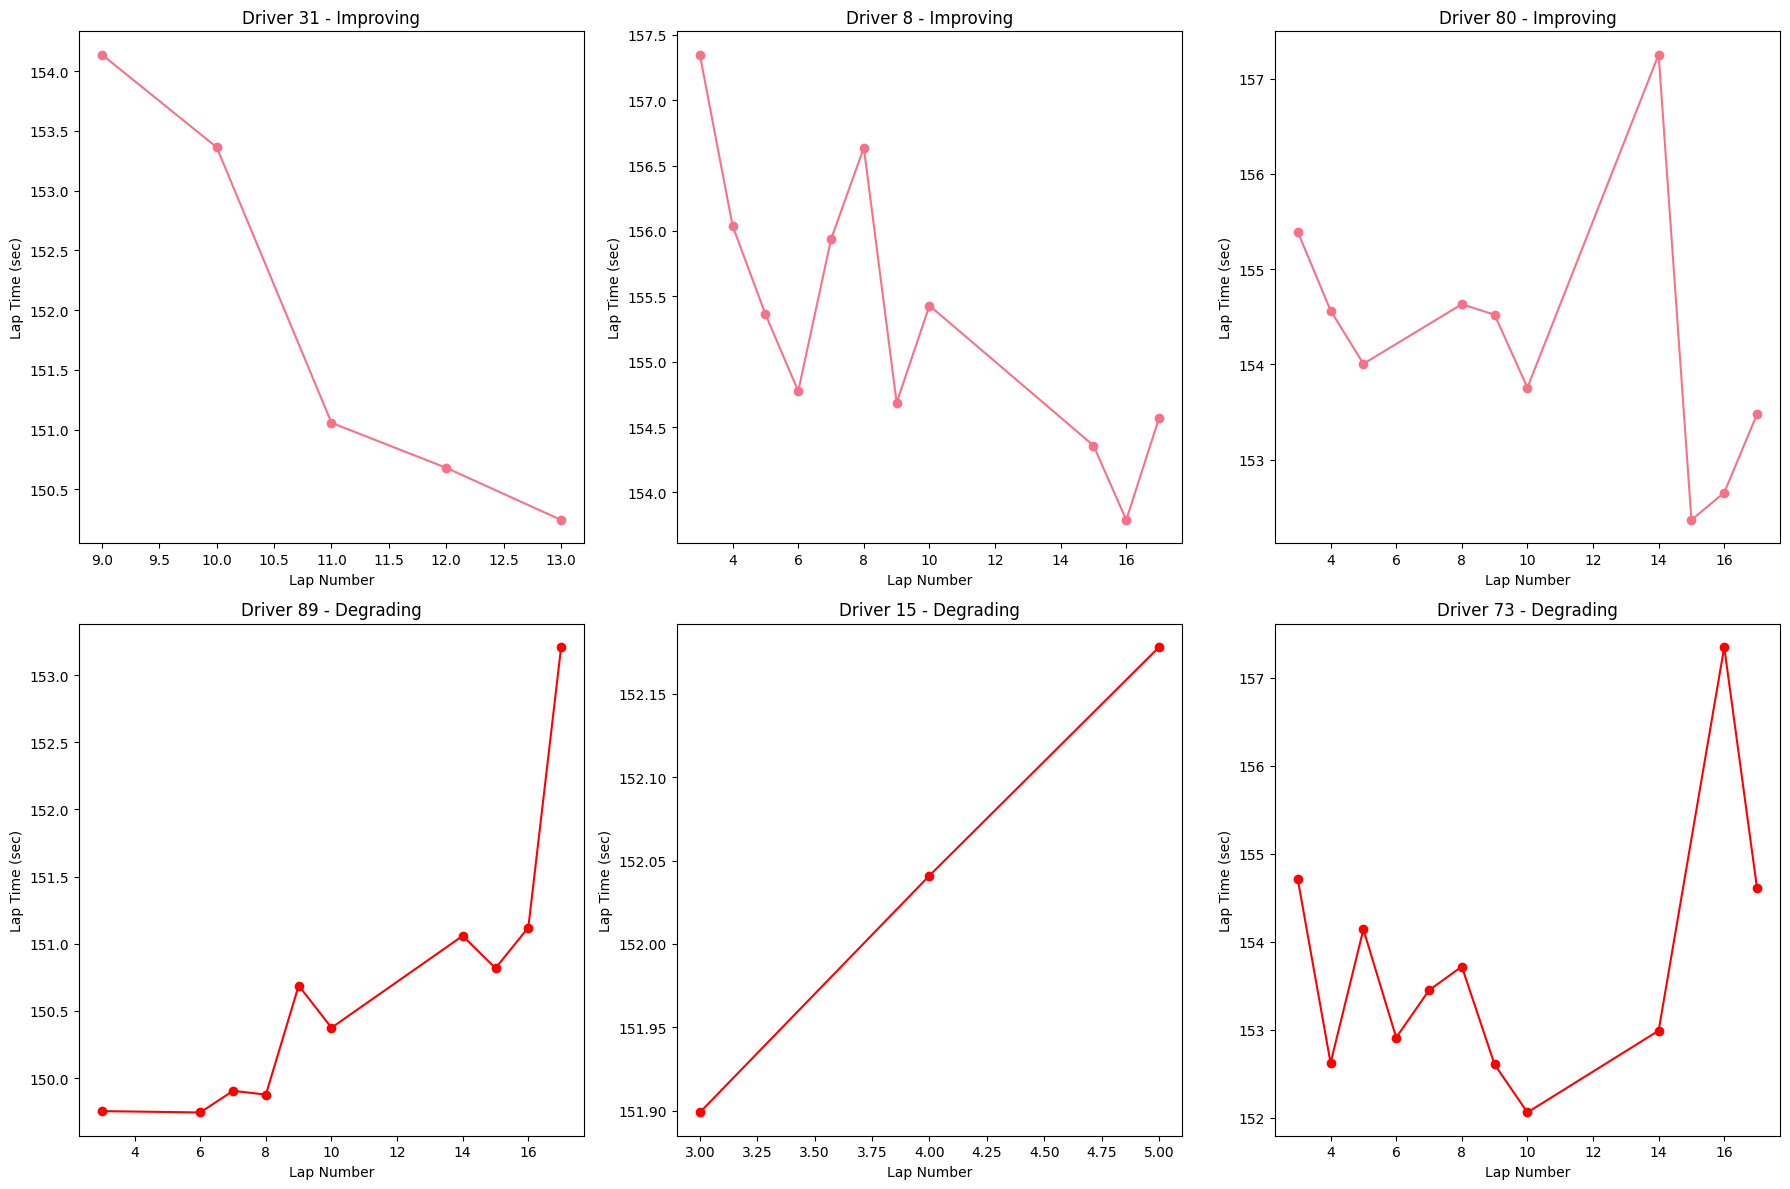

In [19]:
# Visualize performance trends for top improving/degrading drivers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Top 3 improving drivers
top_improving = improving.head(3)['DRIVER_NUM'].values
for i, driver in enumerate(top_improving):
    driver_data = drivers_df[drivers_df['DRIVER_NUM'] == driver].sort_values('LAP_NUMBER')
    axes[0, i].plot(driver_data['LAP_NUMBER'], driver_data['LAP_TIME_SEC'], 'o-')
    axes[0, i].set_title(f'Driver {driver} - Improving')
    axes[0, i].set_xlabel('Lap Number')
    axes[0, i].set_ylabel('Lap Time (sec)')

# Top 3 degrading drivers
top_degrading = degrading.head(3)['DRIVER_NUM'].values
for i, driver in enumerate(top_degrading):
    driver_data = drivers_df[drivers_df['DRIVER_NUM'] == driver].sort_values('LAP_NUMBER')
    axes[1, i].plot(driver_data['LAP_NUMBER'], driver_data['LAP_TIME_SEC'], 'o-', color='red')
    axes[1, i].set_title(f'Driver {driver} - Degrading')
    axes[1, i].set_xlabel('Lap Number')
    axes[1, i].set_ylabel('Lap Time (sec)')

plt.tight_layout()
plt.show()

## Flag Condition Analysis

In [20]:
# Analyze impact of flag conditions
print("=== FLAG CONDITION ANALYSIS ===")

flag_comparison = drivers_df.groupby('FLAG_AT_FL').agg({
    'LAP_TIME_SEC': ['mean', 'std', 'count'],
    'TOP_SPEED': ['mean', 'std'],
    'S1_SEC': 'mean',
    'S2_SEC': 'mean',
    'S3_SEC': 'mean'
}).round(3)

print("Performance by flag condition:")
display(flag_comparison)

# Statistical test for flag impact
flag_values = drivers_df['FLAG_AT_FL'].unique()
print(f"\nFlag conditions present: {flag_values}")

if 'GF' in flag_values and 'FF' in flag_values:
    gf_times = drivers_df[drivers_df['FLAG_AT_FL'] == 'GF']['LAP_TIME_SEC']
    ff_times = drivers_df[drivers_df['FLAG_AT_FL'] == 'FF']['LAP_TIME_SEC']
    
    t_stat, p_value = stats.ttest_ind(gf_times, ff_times)
    print(f"\nT-test GF vs FF lap times:")
    print(f"t-statistic: {t_stat:.3f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

=== FLAG CONDITION ANALYSIS ===
Performance by flag condition:


LAP_TIME_SEC              TOP_SPEED         S1_SEC  S2_SEC  S3_SEC
                   mean    std count      mean    std    mean    mean    mean
FLAG_AT_FL                                                                   
FF              151.926  1.636    23   203.709  3.167  33.093  58.171  60.662
GF              151.516  2.200   302   202.710  3.479  33.086  58.140  60.290


Flag conditions present: ['GF' 'FF']

T-test GF vs FF lap times:
t-statistic: -0.875
p-value: 0.3823
Significant difference: No


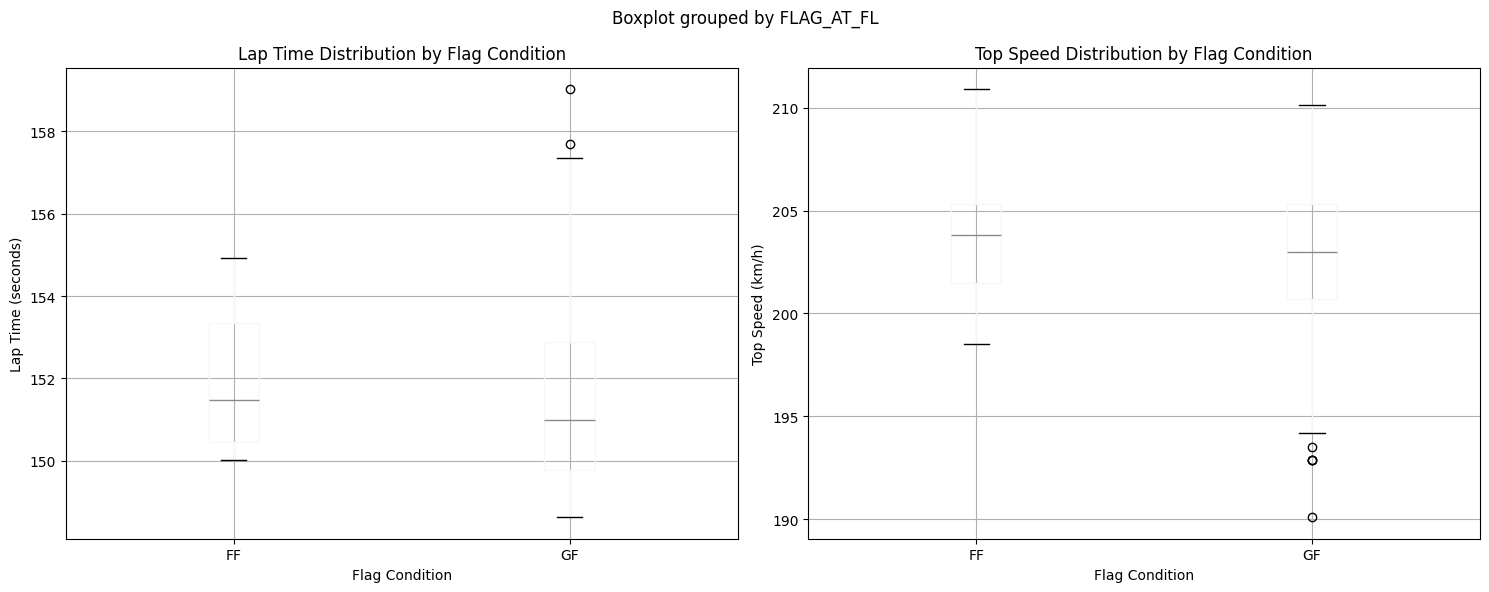

In [21]:
# Visualize flag impact
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of lap times by flag condition
drivers_df.boxplot(column='LAP_TIME_SEC', by='FLAG_AT_FL', ax=axes[0])
axes[0].set_title('Lap Time Distribution by Flag Condition')
axes[0].set_xlabel('Flag Condition')
axes[0].set_ylabel('Lap Time (seconds)')

# Box plot of top speeds by flag condition
drivers_df.boxplot(column='TOP_SPEED', by='FLAG_AT_FL', ax=axes[1])
axes[1].set_title('Top Speed Distribution by Flag Condition')
axes[1].set_xlabel('Flag Condition')
axes[1].set_ylabel('Top Speed (km/h)')

plt.tight_layout()
plt.show()

## Summary Insights

In [22]:
print("=== SUMMARY INSIGHTS ===")
print("\n1. DRIVER PERFORMANCE DISTRIBUTION:")
print(f"   - Fastest driver: {best_laps.index[0]} ({best_laps.iloc[0]:.3f}s)")
print(f"   - Slowest driver: {best_laps.index[-1]} ({best_laps.iloc[-1]:.3f}s)")
print(f"   - Performance gap: {best_laps.iloc[-1] - best_laps.iloc[0]:.3f}s")

print("\n2. CONSISTENCY PATTERNS:")
if len(most_consistent) > 0:
    print(f"   - Most consistent driver: {most_consistent.index[0]} (±{most_consistent.iloc[0]:.3f}s)")
    print(f"   - Least consistent driver: {most_consistent.index[-1]} (±{most_consistent.iloc[-1]:.3f}s)")

print("\n3. TELEMETRY CORRELATIONS:")
if significant_corrs:
    strongest_corr = max(significant_corrs, key=lambda x: abs(x['Correlation']))
    print(f"   - Strongest correlation: {strongest_corr['Variables']} (r={strongest_corr['Correlation']:.3f})")
    print(f"   - Total significant correlations: {len(significant_corrs)}")
else:
    print("   - No statistically significant correlations found")

print("\n4. PERFORMANCE TRENDS:")
improving_count = len(trends_df[trends_df['trend_slope'] < 0])
degrading_count = len(trends_df[trends_df['trend_slope'] > 0])
print(f"   - Drivers improving: {improving_count}")
print(f"   - Drivers degrading: {degrading_count}")

print("\n5. FLAG CONDITIONS:")
for flag in flag_values:
    flag_data = drivers_df[drivers_df['FLAG_AT_FL'] == flag]
    print(f"   - {flag}: {len(flag_data)} laps, avg time {flag_data['LAP_TIME_SEC'].mean():.3f}s")

=== SUMMARY INSIGHTS ===

1. DRIVER PERFORMANCE DISTRIBUTION:
   - Fastest driver: 46 (148.630s)
   - Slowest driver: 8 (153.790s)
   - Performance gap: 5.160s

2. CONSISTENCY PATTERNS:
   - Most consistent driver: 98 (±0.303s)
   - Least consistent driver: 31 (±1.739s)

3. TELEMETRY CORRELATIONS:
   - Strongest correlation: LAP_TIME_SEC_vs_mean_throttle (r=-0.640)
   - Total significant correlations: 15

4. PERFORMANCE TRENDS:
   - Drivers improving: 11
   - Drivers degrading: 18

5. FLAG CONDITIONS:
   - GF: 302 laps, avg time 151.516s
   - FF: 23 laps, avg time 151.926s


## Export Results

In [23]:
# Save analysis results
output_dir = "../analysis_results"
os.makedirs(output_dir, exist_ok=True)

# Save correlation results
if significant_corrs:
    sig_corr_df = pd.DataFrame(significant_corrs)
    sig_corr_df.to_csv(os.path.join(output_dir, "significant_correlations.csv"), index=False)
    print("Saved significant correlations to analysis_results/significant_correlations.csv")

# Save consistency analysis
consistency_stats.to_csv(os.path.join(output_dir, "driver_consistency_stats.csv"))
print("Saved consistency stats to analysis_results/driver_consistency_stats.csv")

# Save performance trends
trends_df.to_csv(os.path.join(output_dir, "performance_trends.csv"), index=False)
print("Saved performance trends to analysis_results/performance_trends.csv")

# Save merged dataset for further analysis
merged_df.to_csv(os.path.join(output_dir, "merged_driver_telemetry.csv"), index=False)
print("Saved merged dataset to analysis_results/merged_driver_telemetry.csv")

print("\nAnalysis complete! Check the analysis_results folder for exported data.")

Saved significant correlations to analysis_results/significant_correlations.csv
Saved consistency stats to analysis_results/driver_consistency_stats.csv
Saved performance trends to analysis_results/performance_trends.csv
Saved merged dataset to analysis_results/merged_driver_telemetry.csv

Analysis complete! Check the analysis_results folder for exported data.
